# Deep Learning Tutorial: An Introduction to Neural Networks

In this tutorial you are going to learn the basics of neural networks. We will walk through each of the different parts that make up a neural network. In the end, we will put these parts together to create a model that can classify animals from a zoo dataset. The zoo dataset was taken from [KEEL](https://sci2s.ugr.es/keel/category.php?cat=clas&order=clasR#sub2).

The model will be developed from first principles using `Numpy`. This means we can see the inner workers of the neural network and how each part works together.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

## What is a neural network?
So, what is a neural network. A neural network can be thought of as a more complicated linear equation.

$y = m*x + b$

Given some input (`x`), the model applies some weights (`m`) and biases (`b`) to predict an outcome, `y`.

But, why is it called 'neural'? That seems to imply something related to the brain. For that, we need to introduce the perceptron.

## What is a perceptron?
The perceptron is the most basic unit of a neural network. It functions much like a neuron in our brain. Each neuron in our brain receives signals from dendrites. Depending on the signals received, the neuron will fire or remain quite.

The perceptron functions in much the same way. Each perceptron receives inputs from adjoining perceptrons. It will then combine these inputs and output either zero or a non-zero value. The functions that are used to make these decisions are called activation functions. Let's take a look at a couple of these activation functions.

### Sigmoid Activation
This activation function sets all inputs to values between 0 and 1. It does this using an exponential function.

In [2]:
def sigmoid_activation(Z):
    activation = 1/(1 + np.exp(-1*Z))
    return activation

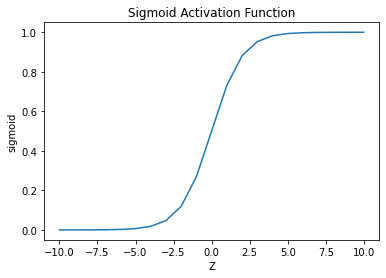

In [3]:
Z = np.arange(21) - 10
sigmoid = sigmoid_activation(Z)
plt.plot(Z, sigmoid)
plt.title('Sigmoid Activation Function')
plt.xlabel('Z')
plt.ylabel('sigmoid')
plt.show()

### Relu Activation
This activation function sets all negative values to 0 and otherwise returns the positive value.

In [4]:
def relu_activation(Z):
    activation = np.maximum(0.0, Z)
    return activation

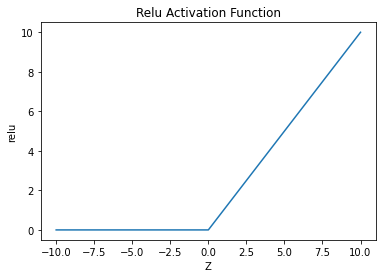

In [5]:
Z = np.arange(21) - 10
relu = relu_activation(Z)
plt.plot(Z, relu)
plt.title('Relu Activation Function')
plt.xlabel('Z')
plt.ylabel('relu')
plt.show()

### Softmax Function
In our model, we are going to perform classification. Therefore, the neural network needs a way to predict a class as output, given some input features. This can be achieved by using a softmax function, which assigns a probability to each class. All probabibilities add up to one. The class with the highest probability is assigned the prediction for that class. The hidden layers allow the neural network to learn complex relationships between the input features to help it make predictions. 

In [6]:
def softmax_activation(Z):
    exp_Z = np.exp(Z - np.max(Z))
    activation = exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
    return activation

### Connecting Perceptrons
Now that we have the 'neurons' (perceptrons) of the neural network, we need to create the network by connecting perceptrons together. Neurons are aligned in layers. The features are received as inputs to the initial layer. The final layer returns a prediction for the model. Inbetween are hidden layers. They are called hidden because we do not have access to information passed to these neurons. See Figure 1 for an example of a neural network.

<img src="./images/neural_network_architecture.png" alt="Drawing" style="width: 600px;"/>
<span>Figure 1: Gradient Overview</span>
<span halign='center'>Image from <a href="https://freecontent.manning.com/neural-network-architectures/">Neural Networks Archictures</a></span>

Let's define the architecture that we will use for our model. 

In [7]:
NUM_FEATURES = 20
NUM_CLASSES = 7
LAYER_SIZES = [25, 25]

LAYER_SIZES.insert(0, NUM_FEATURES)

LAYER_SIZES.append(NUM_CLASSES)

LAYER_ACTIVATIONS = ['relu', 'relu', 'softmax']

In [8]:
print(f'The layer sizes include: {LAYER_SIZES}.')

The layer sizes include: [20, 25, 25, 7].


Out dataset contains 20 features, so that is the input. The first and second hidden layers contain 25 neurons. The final layer is the softmax layer, with seven outputs, one of each type of animal being predicted.

### How are values passed between layers?

Mathematically, this is done by using a weighted sum function. For each layer, the inputs to the perceptrons are multiplied by a weight. The weighted inputs are then added together. Finally, a bias term is added to the sum. This can be done exhaustively. But, a more elegant way is using linear algebra. Here is an example using numpy:

`Z = np.dot(np.transpose(W), X) + b`

`Z` is now a vector of size equal to the number of neurons in the layer. The vector `Z` now passes through an activation function before being passed to the next layer in the neural network.

### Layer Initialization
One of the most import steps in setting up a neural network is initializing the weights and biases. Basically, the neural network needs a starting point at which to begin it's learning process. The choice of initial values is very important. If all values are the same, then the outputs to each hidden layer will be the same. This will prevent each neuron in the hidden layer from learning anything useful. To prevent this problem, the weights and biases are initialized to small values. Let's initialize our neural network.

In [9]:
def initialize_network():
    architecture = {}
    for layer in range(1, len(LAYER_SIZES)):
        architecture[f'layer_{layer}'] = {
            'W': np.random.randn(LAYER_SIZES[layer],
                                 LAYER_SIZES[layer-1]) * 0.1,
            'b': np.random.randn(LAYER_SIZES[layer], 1) * 0.1,
            'activation': LAYER_ACTIVATIONS[layer-1]
        }
    return architecture

In [10]:
network = initialize_network()

### Single Forward Pass
Ok, now we have defined our neural network architecture and have initialized all weights and biases. We now need to define a function that will pass values from layer to layer.

In [11]:
act_map = {
    'sigmoid': sigmoid_activation,
    'relu': relu_activation,
    'softmax': softmax_activation
}

In [12]:
def single_forward_pass(A_previous, W, b, activation):
    try:
        act_function = act_map[activation]
    except KeyError:
        print(f'The activation {activation} is not recognized.\nIt must be one of the following: {list(act_map.keys())}')
        return None
    
    Z = np.dot(W, A_previous) + b
    A = act_function(Z)
    
    return A, Z

This function uses linear algebra to perform the weighted sum for each layer that was discussed above. It outputs the activated outputs `A` and the non-activated outputs `Z`.

### Full Foward Pass
In the next function I define, we loop through each layer in the network and perform a forward pass using `single_forward_pass()`. All activated outputs `A` and non-activate outputs `Z` will be stored for later use. After the inputs have been passed in, the final output will be the predictions for each label.

In [13]:
def full_forward_pass(X, network):
    
    cache = {}
    A = np.transpose(X)
    
    for layer in range(1, len(network) + 1):
        A_previous = A
        A, Z = single_forward_pass(A_previous,
                                   network[f'layer_{layer}']['W'], 
                                   network[f'layer_{layer}']['b'], 
                                   network[f'layer_{layer}']['activation'])
        
        cache[f'A_{layer-1}'] = A_previous
        cache[f'Z_{layer}'] = Z
        
    return A, cache

### Model Evaluation
After making predictions, we need a way to evaluate the model. We would like to know how well the model can predict each label. The simplest method is to compute the accuracy. For each prediction, compare it to the true value. Then count up the fraction of correct predictions. Here is a function to do that:

In [14]:
def compute_accuracy(y_pred, y):
    y_pred_transpose = np.transpose(y_pred)
    y_pred_flat = np.argmax(y_pred_transpose, 1)
    y_flat = np.argmax(y, 1)
    accuracy = np.mean(y_pred_flat == y_flat)
    return accuracy

You will notice that periodically I will using `np.transpose()`. This will ensure that when comparing predictions and labels, each will have the same shape.

### Cross Entropy Cost Function
While accuracy can provide a quick way to assess model performance, it does not provide much information on how well the model does at predicting each of the different classes. As shown above, the output of the softmax function will produce probabilities for each class for each sample in the training set. We can compare the probabilities to the actual values using a cross entropy function. Here is the formula:

$cost = -1 * \sum \limits _{i} ^m y_{i} * log(y'_{i})$

Where $y$ is the true value and $y'$ is the prediction.

Here is how we can code up cross entropy in numpy:

In [15]:
def compute_cross_entropy_cost(y_pred, y):
    
    cost = -1*np.mean(y * np.log(np.transpose(y_pred)))
    
    return cost

Great! Now we have a way to evaluate how well out model is at classification. But, out model will be useless if it can't learn anything. We need it to be able to decide how to update it's weights and biases in order to improve it's ability to make predictions.

### Gradients
During training, we want our model to search for the best fit. This will be the combination of parameters that yields the smallest cost function. In simplest terms, this search space can be thought of as a parabola, where the lowest point in the best cost for the model (see Figure 2 below). These are the steps the model will take:

1. Make a prediction.
2. Update weights and biases.
3. Make a new prediction.
4. Compare old and new predictions.

But, can we update the weights and biases in an intelligent way, instead of making random guesses?

<img src="./images/gradient-overview.png" alt="Drawing" style="width: 400px;"/>
<span>Figure 2: Gradient Overview</span>
<span halign='center'>Image from <a href="https://lucidar.me/en/neural-networks/single-layer-gradient-descent/">Gradient descent for neural networks</a></span>

### Back Propagation

If you look at two points on the parabola above, we can draw a line between them. This line has some slope, or gradient. The gradient points towards the optimal model fit at the bottom of the parabola. If we can compute this gradient, then we have an intelligent way to tell the model how to update the weights and biases. And, it turns out we can... using calculus! The derivative in calculus is a measure of the gradient. After completing a forward pass, we can go backwards through the network, calculating the derivatives at each layer. This will give us a measure of the gradients for each layer. Using the gradient, we can update the weights and biases in a smart way, allowing the model to learn.

The calculus involved is beyond the scope of this tutuorial. Below I will provide the derivative functions for each activation function.

In [16]:
def dZ_sigmoid(dA, Z):
    sigmoid = sigmoid_activation(Z)
    dZ = dA * sigmoid * (1.0 - sigmoid)
    return dZ

In [17]:
def dZ_softmax(dA, Z):
    softmax = softmax_activation(Z)
    dZ = dA * softmax * (1.0 - softmax)
    return dZ

In [18]:
def dZ_relu(dA, Z):
    dZ = np.copy(dA)
    dZ[Z <= 0.0] = 0.0
    return dZ

#### Single Backward Pass
In the next function, I calculate the derivatives for a single layer, `dZ`. Then, I compute the derivatives for the weights (`dW`) and biases (`db`). And, finally, the derivative of the activation function.

In [19]:
dZ_map = {
    'sigmoid': dZ_sigmoid,
    'relu': dZ_relu,
    'softmax': dZ_softmax
}

In [20]:
def single_backward_pass(dA, W, b, Z, A_previous, activation):
    
    try:
        backprop_activation = dZ_map[activation]
    except KeyError:
        print(f'The backprop activation {activation} is not recognized.\nIt must be one of the following: {list(dZ_map.keys())}')
        return None
    
    m = A_previous.shape[1]
    
    dZ = backprop_activation(dA, Z)
    
    dW = np.dot(dZ, np.transpose(A_previous)) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_previous = np.dot(np.transpose(dW), dZ)
    
    return dA_previous, dW, db

#### Full Backward Pass
Each single backward pass will be combined as we step backwards through each layer in the neural network. After each step, the gradients for the weights and biases will be stored. These will be used to update the model in the next step.

In [21]:
def full_backward_pass(y_pred, y, cache, network):
    
    stored_grads = {}
    m = y.shape[1]
    
    dA_previous = y_pred - np.transpose(y)
    
    for layer in reversed(range(1, len(network) + 1)):
        activation = network[f'layer_{layer}']['activation']
        layer_previous = layer - 1
        
        dA = dA_previous
        
        A_previous = cache[f'A_{layer_previous}']
        Z = cache[f'Z_{layer}']
        W = network[f'layer_{layer}']['W']
        b = network[f'layer_{layer}']['b']
        
        dA_previous, dW, db = single_backward_pass(dA, W, b, Z, A_previous, activation)
        stored_grads[f'dW_{layer}'] = dW
        stored_grads[f'db_{layer}'] = db
        
    return stored_grads

### Update the Model
In this function, I update the current weights and biases with new weights and biases for each layer using the gradients that were calculated during back propogation. This function takes an additional argument, called the learning rate. As you can see, the gradients are multiplied the the learning rate. Therefore, this parameter determines how fast the model can update its parameters. The learning rate basically controls the step size, as shown in the image above. If the learning rate is large, the model will take large steps as it tries to find the optimal fit. If the learning rate is small, the model will take small steps in the direction of the optimal fit. If the learning rate it too large, the model could bounce back and forth across the optimal fit without finding the best set of values. But, if the learning rate is too small, it could take the model forever to find the best fit. Therefore, the learning rate needs to be iteratively adjusted to find the best value for a given problem.

In [22]:
def update_network(network, stored_grads, learning_rate):
    for layer in range(1, len(network) + 1):
        network[f'layer_{layer}']['W'] = network[f'layer_{layer}']['W'] - learning_rate * stored_grads[f'dW_{layer}']
        network[f'layer_{layer}']['b'] = network[f'layer_{layer}']['b'] - learning_rate * stored_grads[f'db_{layer}']
    return network

## Train the Model
Now that we have created all the pieces for our neural network, we can put them together in a function to train our model.

In [23]:
def train_nn(X, y, network):
    
    stored_cost = []
    
    for epoch in range(HYPER_PARAMS['epochs']):
        y_pred, cache = full_forward_pass(X, network)
        cost = compute_cross_entropy_cost(y_pred, y)
        if epoch == 0:
            print(f' * The initial cost is {cost:0.3f}.')
        stored_cost.append(cost)
        stored_grads = full_backward_pass(y_pred, y, cache, network)
        network = update_network(network, stored_grads, HYPER_PARAMS['learning_rate'])
    final_accuracy = compute_accuracy(y_pred, y)
    print(f' * Final cost: {cost:0.3f}.')
    print(f' * Final accuracy: {final_accuracy:0.3%}')
    return network, stored_cost, y_pred

But, before actually training the model, there are a few things we need to do to the dataset.

## Data Preprocessing
### Load Dataset
We will load the dataset into a Pandas `DataFrame`.

In [24]:
header_values = []
with open('./data/zoo.dat', 'r') as zoo_file:
    for line in zoo_file:
        if '@attribute' in line:
            header_values.append(line.split()[1])

In [25]:
df = pd.read_csv('./data/zoo.dat', skiprows=21, header=None, names=header_values)

In [26]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Hair,101.0,0.425743,0.496921,0.0,0.0,0.0,1.0,1.0
Feathers,101.0,0.198020,0.400495,0.0,0.0,0.0,0.0,1.0
Eggs,101.0,0.584158,0.495325,0.0,0.0,1.0,1.0,1.0
Milk,101.0,0.405941,0.493522,0.0,0.0,0.0,1.0,1.0
Airborne,101.0,0.237624,0.427750,0.0,0.0,0.0,0.0,1.0
Aquatic,101.0,0.356436,0.481335,0.0,0.0,0.0,1.0,1.0
Predator,101.0,0.554455,0.499505,0.0,0.0,1.0,1.0,1.0
Toothed,101.0,0.603960,0.491512,0.0,0.0,1.0,1.0,1.0
Backbone,101.0,0.821782,0.384605,0.0,1.0,1.0,1.0,1.0
Breathes,101.0,0.792079,0.407844,0.0,1.0,1.0,1.0,1.0


### Separate Features and Labels
Next, we need to separate the features and labels. Each feature is some characteristic of an an animal, as shown above. The labels are in column _Type_.

In [27]:
df_X = df.drop(columns='Type')  # Features

In [28]:
df_y = df['Type']  # Labels

### One-hot Encode Features
When training a machine learning model, it will perform better if all features are scaled to the same range of values. In looking at the table above you will notice that all features except _Legs_ have values that are either one or zero. In addition, _Legs_ is a categorical variable and so we can't scale it using a numerical transformation. Instead, we can encode each label as a vector of 1's and 0's, which is called one-hot encoding.

#### What is one-hot encoding?

Let's say we are categorizing fruit and we have the following categories:

`['apples', 'bananas', 'pears', 'peaches']`

Let's say we have the label 'bananas', we can encode it using one's and zero's using the catergory list above. We will place a 1 for the index in the list that corresponds to 'bananas' and 0 elsewhere. Therefore, the one-hot encoded vector for bananas will be:

`[0, 1, 0, 0]`

We can reduce the length of the one-hot vector, but retain the same information, but dropping one of the categories in the category list:

`['apples', 'bananas', 'pears']`

In this case, the label 'peaches' would correspond to the following vector:

`[0, 0, 0]`

One-hot encoding in Python can be done using Pandas `get_dummies()` method.

In [29]:
df_X_one_hot = pd.get_dummies(df_X, columns=['Legs'], drop_first=True)

In [30]:
df_X_one_hot.describe().T

,count,mean,std,min,25%,50%,75%,max
Hair,101.0,0.425743,0.496921,0.0,0.0,0.0,1.0,1.0
Feathers,101.0,0.198020,0.400495,0.0,0.0,0.0,0.0,1.0
Eggs,101.0,0.584158,0.495325,0.0,0.0,1.0,1.0,1.0
Milk,101.0,0.405941,0.493522,0.0,0.0,0.0,1.0,1.0
Airborne,101.0,0.237624,0.427750,0.0,0.0,0.0,0.0,1.0
Aquatic,101.0,0.356436,0.481335,0.0,0.0,0.0,1.0,1.0
Predator,101.0,0.554455,0.499505,0.0,0.0,1.0,1.0,1.0
Toothed,101.0,0.603960,0.491512,0.0,0.0,1.0,1.0,1.0
Backbone,101.0,0.821782,0.384605,0.0,1.0,1.0,1.0,1.0
Breathes,101.0,0.792079,0.407844,0.0,1.0,1.0,1.0,1.0


In [31]:
X = df_X_one_hot.values

### One-hot Encode Labels
We will also one-hot encode the labels, since these are categorical variables. Furthermore, since we are using softmax to make predictions, which encodes the labels as vectors of class probability, we need the true labels to also be vectors. This will allow us to evaluate the model in the way we discussed earlier.

In [32]:
NUM_CLASSES = len(pd.unique(df_y))
print(f'There are {NUM_CLASSES} unique classes for the labels, which are {pd.unique(df_y)}.')

There are 7 unique classes for the labels, which are [1 4 7 2 6 3 5].


In [33]:
def encode_labels(x):
    encoded = np.zeros(NUM_CLASSES)
    encoded[x-1] = 1
    return encoded

In [34]:
df_y_one_hot = df_y.apply(lambda x: encode_labels(x))

In [35]:
df_y_one_hot.head()

0    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
2    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
3    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
4    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
Name: Type, dtype: object

In [36]:
y = df_y_one_hot.values

In [37]:
y = np.stack(y)

## Train the Model
At this point the data has been prepared for modeling. During modeling, we are going to define two hyperparameters. Hyperparameters are parameters that can be chosen to adjust how the model trains. In this case, we will use _epochs_ and _learning_rate_. The learning rate was discussed early. Epochs controls how many times the model will update its parameters in search of the best model fit.

In [38]:
HYPER_PARAMS = {
    'epochs': 10000,
    'learning_rate': 20
}

Let's run the model and evaluate it's performance.

In [39]:
network, stored_cost, y_pred = train_nn(X, y, network)

 * The initial cost is 0.278.
 * Final cost: 0.479.
 * Final accuracy: 45.545%


Wow! While the cost is small, the accuracy really isn't good! In order to understand why this might be, let's take a look at the distribution in different classes for the labels.

In [40]:
def compute_label_counts(y):
    y_label_summary = pd.Series(y).value_counts(normalize=True).reset_index().sort_values(by='index')
    y_label_summary.columns = ['Label', 'Fraction']
    return y_label_summary

In [41]:
y_counts = compute_label_counts(df_y)

In [42]:
y_counts

,Label,Fraction
0,1,0.405941
1,2,0.198020
5,3,0.049505
2,4,0.128713
6,5,0.039604
4,6,0.079208
3,7,0.099010


You will notice that 40% of the values are of class 1, 20% are of class 2, 13% are of class 4, while the rest of the classes are much smaller. This unequal distribution in classes is called class imbalance.

Let's take a look at the distribution in classes for the predictions.

In [43]:
def flatten_label_predictions(y_pred):
    y_pred_transpose = np.transpose(y_pred)
    y_pred_flat = np.argmax(y_pred_transpose, 1)
    return y_pred_flat

In [44]:
y_pred_flat = flatten_label_predictions(y_pred)

In [45]:
y_pred_flat += 1

In [46]:
y_pred_counts = compute_label_counts(y_pred_flat)

In [47]:
y_pred_counts

,Label,Fraction
0,1,0.762376
3,2,0.059406
4,4,0.009901
2,6,0.079208
1,7,0.089109


Over 80% of the predictions went to class 1. Basically, since class 1 dominates the training set, the model is deciding to classify almost all samples as this class. Therefore, something needs to be done to counter this class imbalance and help the model perform better.

## Challenges

* **1:** Create a model using numpy that handles the class imbalance.
* **2:** Play with the network architecture (number of layers, number of nodes per layer, activation functions) to see if you can improve the model performance.
* **3:** Similarly, try improving the model performance by adjusting the hyperparameters.

### Resources
This notebook has been inspired by the Towards Data Science post [Let’s code a Neural Network in plain NumPy](https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795).

Additional resources include:

* [A Gentle Introduction to Cross-Entropy for Machine Learning](https://machinelearningmastery.com/cross-entropy-for-machine-learning/).
* [Creating a Neural Network from Scratch in Python: Multi-class Classification](https://stackabuse.com/creating-a-neural-network-from-scratch-in-python-multi-class-classification/).
* [The Softmax Function Derivative (Part 1)](https://aimatters.wordpress.com/2019/06/17/the-softmax-function-derivative/).
* [Understanding and implementing Neural Network with SoftMax in Python from scratch](http://www.adeveloperdiary.com/data-science/deep-learning/neural-network-with-softmax-in-python/)